In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation


In [2]:
data_dir = script_dir / "20D_new_data"
TRAINING_SAMPLES_FILE = data_dir / "train_20D_1000LHS.dat"
TEST_SAMPLES_FILE = data_dir / "test_20D_100LHS.dat"

## Load & process input data

In [3]:
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
TEST_SAMPLES_FILE = shutil.copy(TEST_SAMPLES_FILE, tmp_folder)

In [7]:
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(TRAINING_SAMPLES_FILE)
PROCESSED_TEST_FILE = funs_data_processing.process_input_file(
    TEST_SAMPLES_FILE,
    columns_to_remove=[
        "interface",
        "AFmax_4um",
        "GAFmax_4um",
    ],  # remove the output column; needs to be evaluated
)

In [9]:
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)
variables_test = funs_data_processing.get_variable_names(PROCESSED_TEST_FILE)
print(variables_test)

['%eval_id', 'RELDEPTH', 'DIAMETER', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF', 'AFmax_4um', 'GAFmax_4um']
['%eval_id', 'RELDEPTH', 'DIAMETER', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF']


## Plot input data (Fig03 & Fig07)

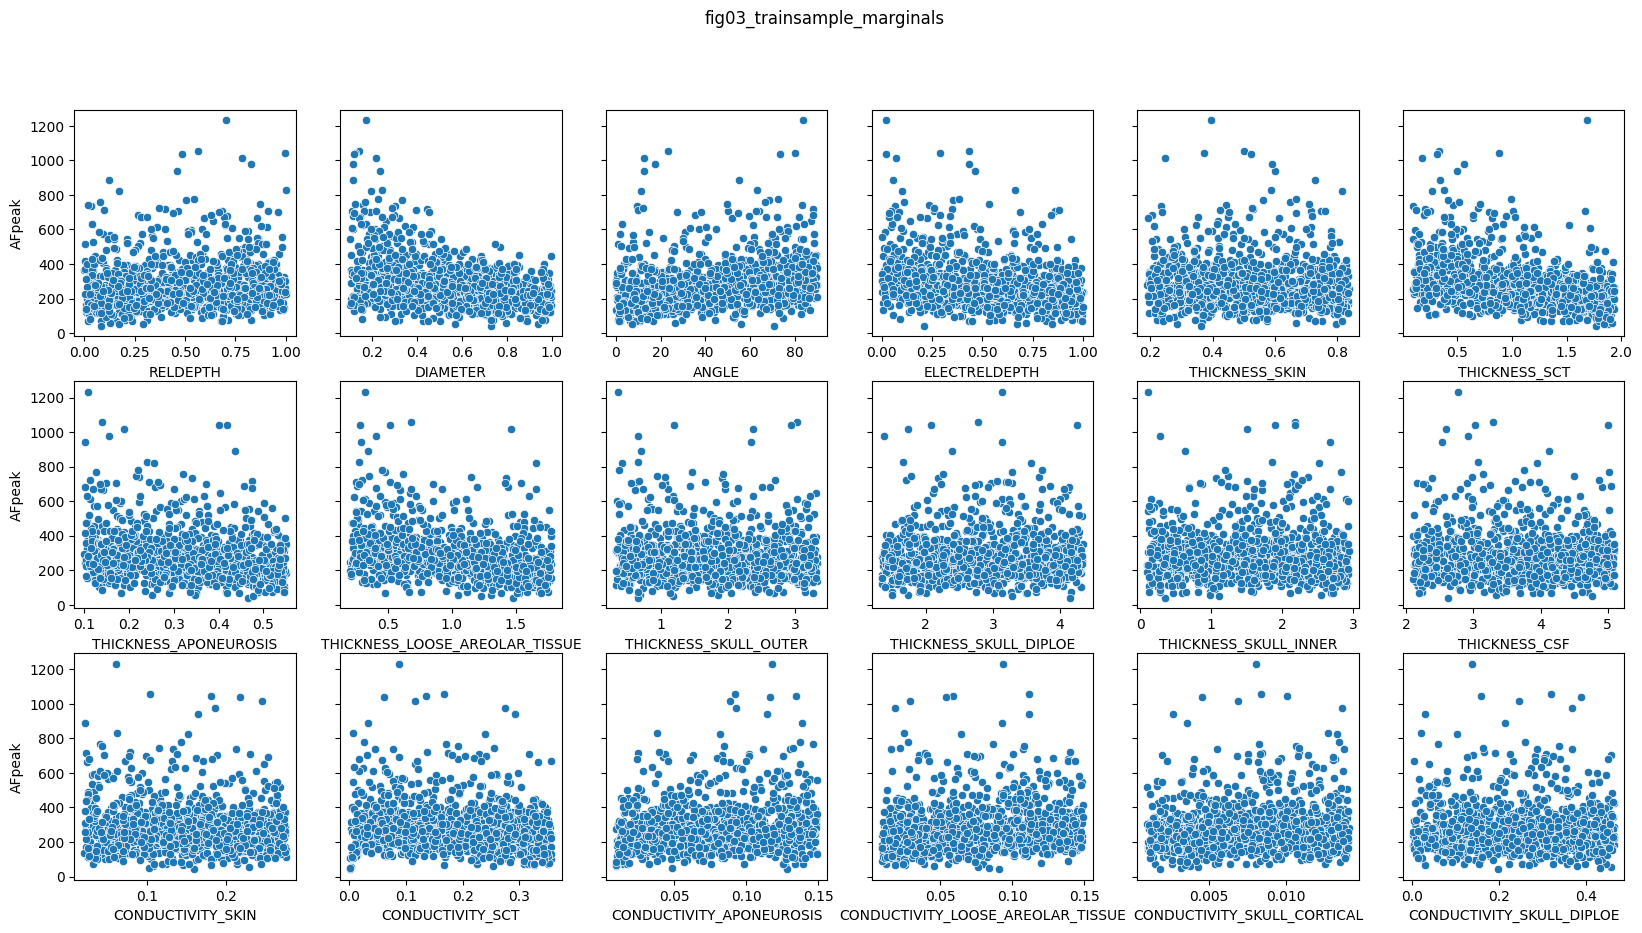

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

title = "fig03_trainsample_marginals"
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
data = funs_data_processing.load_data(PROCESSED_TRAINING_FILE)
data = data.astype(np.float64)
data.rename(columns={"AFmax_4um": "AFpeak"}, inplace=True)
data.head()
axs: List[plt.Axes] = axs.flatten()
# fig, axs = plt.subplots(1,1, figsize=(15, 15), sharey=True)
# axs = [axs]
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="AFpeak", ax=ax)
    # plt.scatter(data[c].values, data["AFpeak"].values)
    ax.set_xlabel(c)
    # ax.hlines(0.0, data[c].min(), data[c].max(), color="black", linestyle="--")
plt.suptitle(title)
plt.show()

## Create & run Dakota study

In [17]:
N_RESPONSES = 2

dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE, cross_validation_folds=5
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(PROCESSED_TEST_FILE)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-N_RESPONSES],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-N_RESPONSES:])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                
                cross_validation folds = 5 
                metrics = "root_mean_squared" "sum_abs" "mean_abs" "max_abs" "rsquared"
                
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_20D_1000LHS_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo responses!!

In [18]:
# os.chdir(tmp_folder)
# study = dakenv.study(
#     callbacks={},  ## DONT NEED ANY MODEL EVALUATIONS
#     input_string=dakota_conf,
# )
# study.execute()
# os.chdir(script_dir)

os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

# import subprocess

# subprocess.run(
#     " ".join(["dakota", "-i", str(dakota_conf_path), "-o", "rest.out"]),
#     shell=True,
#     cwd=tmp_folder,
# )

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Sat Sep  7 11:14:10 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 19 variables and 2 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_20D_1000LHS_processed.txt'
Variables read:
                      6.5990068060e-01 RELDEPTH
                      9.0742225640e-01 DIAMETER
                      5.1662245420e+01 ANGLE
                      7.8771363040e-01 ELECTRELDEPTH
                      8.2602373040e-01 THICKNESS_SKIN
                      8.4350130250e-01 THICKNESS_SCT
                      2.4272472180e-01 THICKNESS_APONEUROSIS
                     

## Evaluate Dakota predictions

In [30]:
RESPONSE = "GAFmax_4um"

y = funs_data_processing.get_results(TEST_SAMPLES_FILE, RESPONSE)
y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)
std = np.sqrt(
    funs_data_processing.get_results(
        tmp_folder / "variances.dat", RESPONSE + "_variance"
    )
)
y_tilde = (y - y_hat) / std

k =  1.5
The data IS normally distributed. p-value: 0.3488245250608629


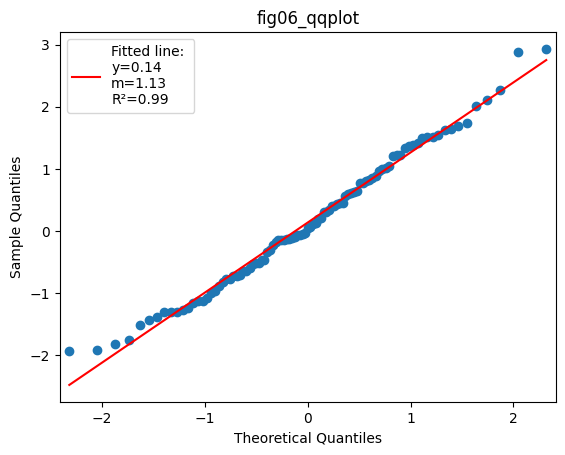

k =  None
The data is NOT normally distributed. p-value: 0.04321786130980667


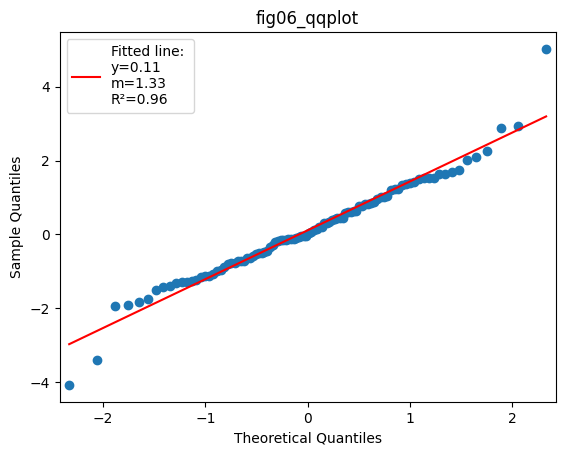

In [31]:
from utils import funs_gp_evaluation
import matplotlib.pyplot as plt

for k in [1.5, None]:  # outlier detection threshold
    print("k = ", k)
    pval = funs_gp_evaluation.test_normality(y_tilde, k)
    slope, intercept, r2 = funs_gp_evaluation.make_qqplot(y_tilde, k, MAKEPLOT=True)
    plt.title("fig06_qqplot")
    plt.show()

In [32]:
data = funs_data_processing.load_data(PROCESSED_TEST_FILE)
data = data.astype(np.float64)
data["y"] = y
data["y_hat"] = y_hat
data["res"] = y - y_hat
data["ares"] = np.abs(y - y_hat)
data["nres"] = y_tilde
data["anres"] = np.abs(y_tilde)
data.head()

%eval_id  RELDEPTH  DIAMETER      ANGLE  ELECTRELDEPTH  THICKNESS_SKIN  \
0       1.0  0.171588  0.252629  47.101657       0.654082        0.812227   
1       2.0  0.713765  0.763464  38.610079       0.443231        0.786025   
2       3.0  0.615695  0.368078  32.140000       0.308187        0.554327   
3       4.0  0.639693  0.295879  63.120619       0.226983        0.418025   
4       5.0  0.038178  0.458976  45.136256       0.764756        0.404953   

   THICKNESS_SCT  THICKNESS_APONEUROSIS  THICKNESS_LOOSE_AREOLAR_TISSUE  \
0       0.681614               0.167554                        1.529913   
1       1.888312               0.541624                        1.527629   
2       0.992357               0.376274                        1.280723   
3       0.257349               0.337524                        0.440735   
4       1.677799               0.273868                        1.222697   

   THICKNESS_SKULL_OUTER  ...  CONDUCTIVITY_LOOSE_AREOLAR_TISSUE  \
0               0.369319  ...                           0.136444   
1               0.890976  ...                           0.087190   
2               1.318159  ...                           0.058729   
3               0.587415  ...                           0.101576   
4               2.494659  ...                           0.094964   

   CONDUCTIVITY_SKULL_CORTICAL  CONDUCTIVITY_SKULL_DIPLOE  CONDUCTIVITY_CSF  \
0                     0.011325                   0.044703          2.366983   
1                     0.007643                   0.312692          0.468163   
2                     0.013925                   0.343229          1.063864   
3                     0.013580                   0.244084          2.891248   
4                     0.012897                   0.253754          1.293836   

           y      y_hat       res      ares      nres     anres  
0   8.895174   8.498578  0.396596  0.396596  0.447288  0.447288  
1   7.906831   7.881255  0.025576  0.025576  0.040855  0.040855  
2   7.058407   5.941976  1.116432  1.116432  1.740331  1.740331  
3  16.523921  14.393407  2.130514  2.130514  2.931445  2.931445  
4   7.531837   6.836700  0.695137  0.695137  0.885438  0.885438  

[5 rows x 26 columns]

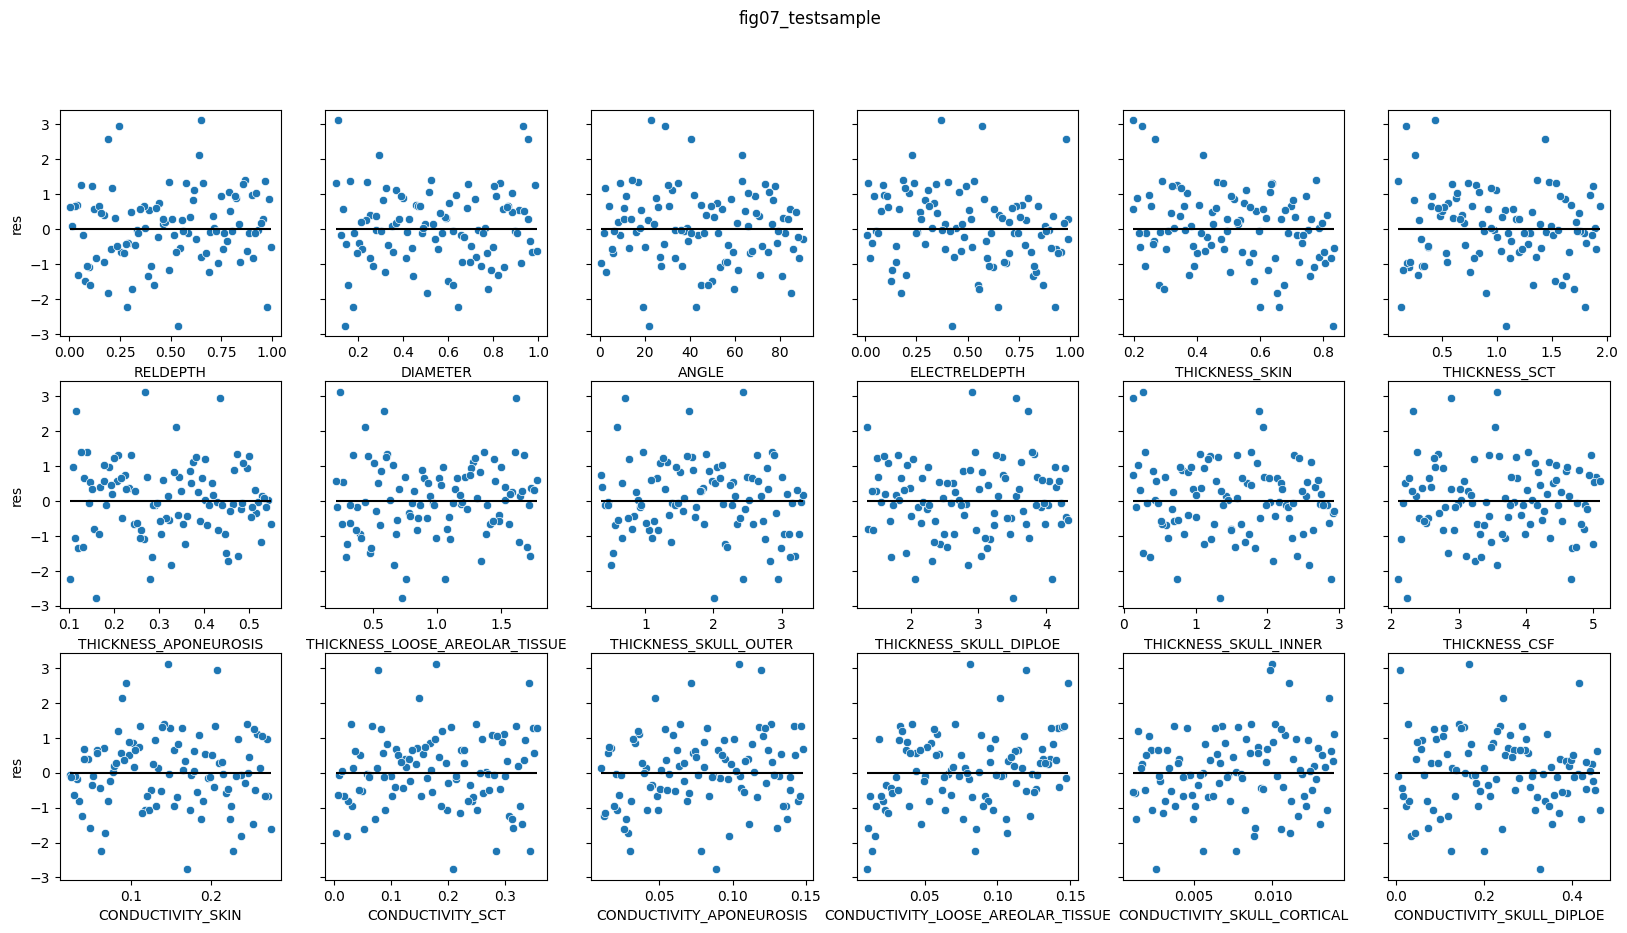

In [33]:
title = "fig07_testsample"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="res", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

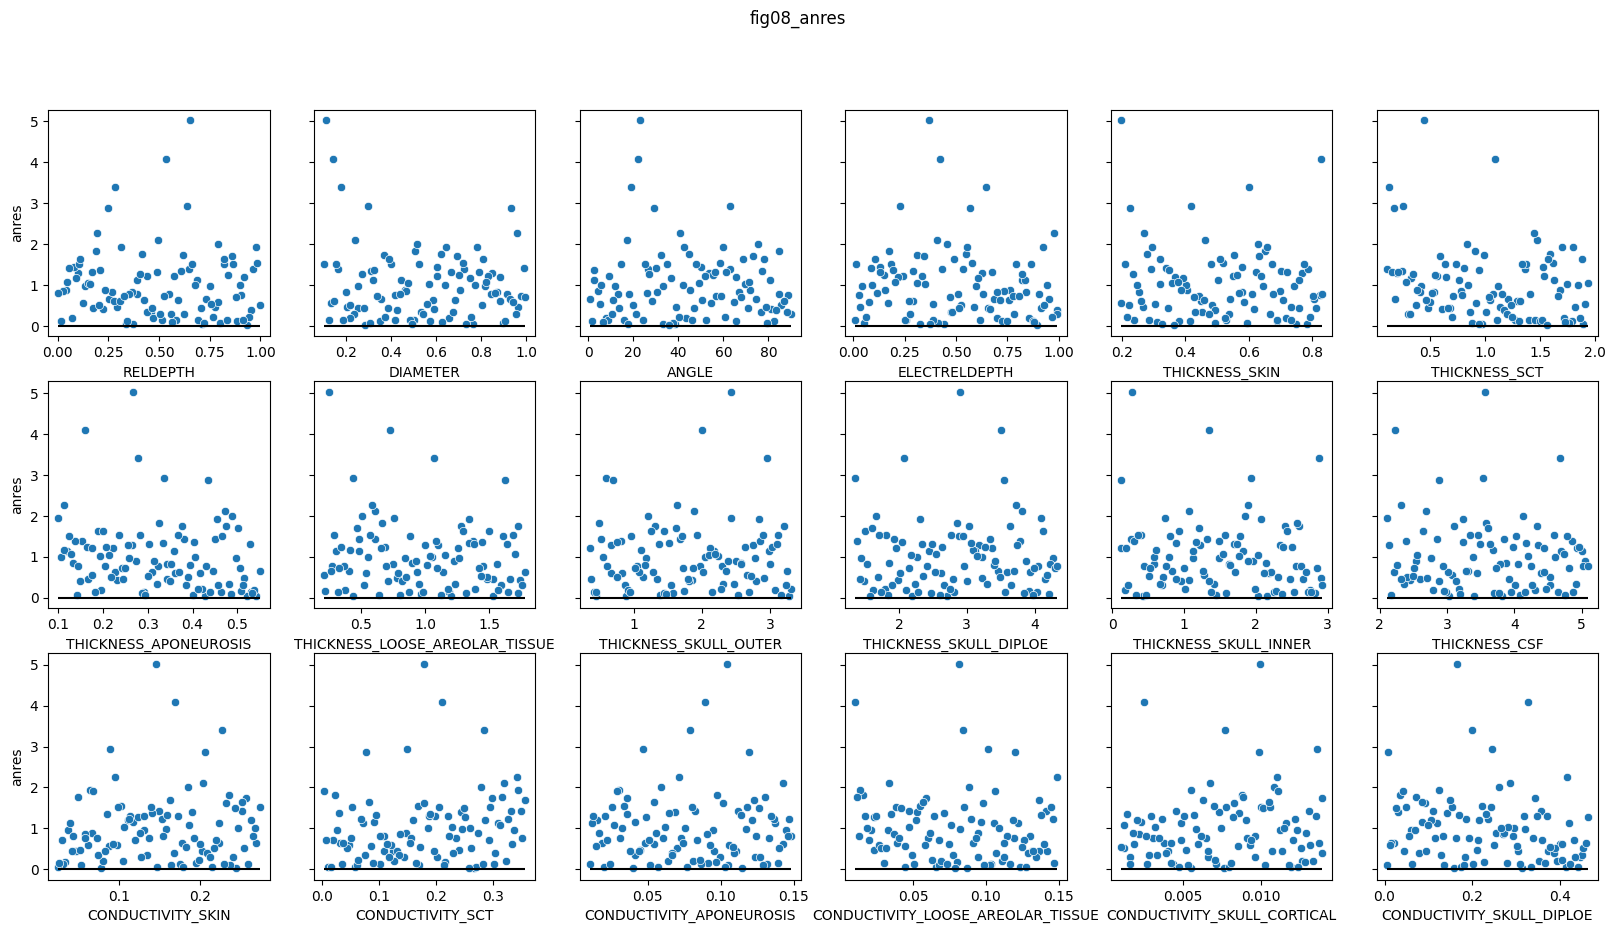

In [34]:
title = "fig08_anres"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="anres", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

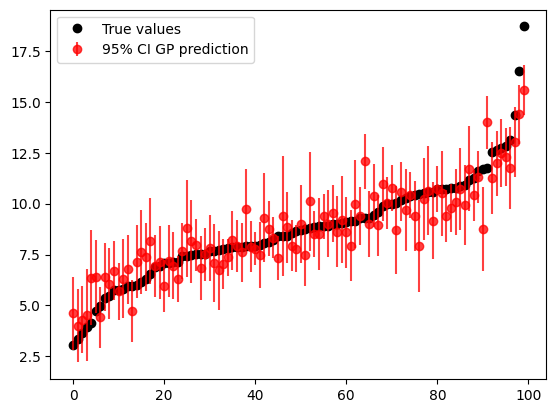

In [38]:
# sorted_idx = np.argsort(y)
# y = y[sorted_idx]
# y_hat = y_hat[sorted_idx]
# std = std[sorted_idx]
plt.plot(y, "ko", label="True values")
plt.errorbar(
    range(len(y_hat)),
    y_hat,
    yerr=2 * std,
    fmt="o",
    color="red",
    alpha=0.75,
    label="95% CI GP prediction",
)
# plt.ylim(-200, 1420)
plt.legend()

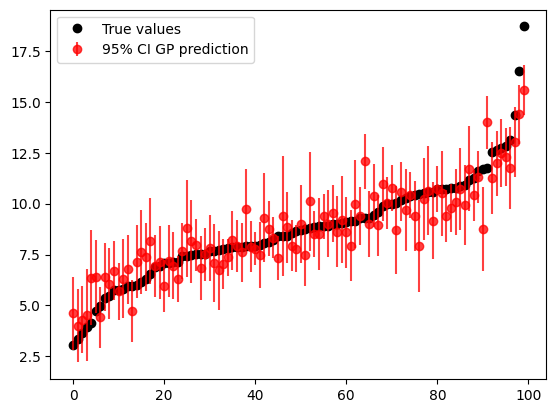

In [39]:
sorted_idx = np.argsort(y)
y = y[sorted_idx]
y_hat = y_hat[sorted_idx]
std = std[sorted_idx]
plt.plot(y, "ko", label="True values")
plt.errorbar(
    range(len(y_hat)),
    y_hat,
    yerr=2 * std,
    fmt="o",
    color="red",
    alpha=0.75,
    label="95% CI GP prediction",
)
# plt.ylim(-200, 1420)
plt.legend()

In [37]:
np.mean(np.abs(y - y_hat))

np.float64(0.8083008858)